<a href="https://colab.research.google.com/github/Iftekhar-mobin/TimeSeriesLSTM/blob/main/Multivariate_Multi_Step_Medium.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reference : https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

Reference : https://towardsdatascience.com/predictive-analytics-time-series-forecasting-with-gru-and-bilstm-in-tensorflow-87588c852915

In [1]:
from tensorflow.keras.models import save_model, load_model

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from pandas import DataFrame , concat
from sklearn.metrics import mean_absolute_error , mean_squared_error
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from numpy import mean , concatenate
from math import sqrt
from pandas import read_csv
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Activation
from numpy import array , hstack
from tensorflow import keras
import tensorflow as tf

# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
df = pd.read_csv('GBPUSD1440.csv',delimiter=',')
df.columns =['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'Volume']

In [4]:
df = df[['Open', 'High', 'Low', 'Close']]

In [5]:
df['avg'] = df.loc[:, ['Open', 'High', 'Low', 'Close']].mean(axis=1)

In [6]:
df

,Open,High,Low,Close,avg
0,1.24212,1.24671,1.23587,1.24252,1.241805
1,1.24250,1.24928,1.24003,1.24497,1.244195
2,1.24494,1.24800,1.24139,1.24738,1.245427
3,1.24585,1.24799,1.24482,1.24782,1.246620
4,1.24781,1.25296,1.23839,1.24064,1.244950
...,...,...,...,...,...
2043,1.25792,1.25990,1.24864,1.25140,1.254465
2044,1.25139,1.26242,1.25128,1.26059,1.256420
2045,1.26058,1.26985,1.26001,1.26702,1.264365
2046,1.26703,1.27900,1.26291,1.27841,1.271837


In [7]:
dataset = df

In [8]:
x_1 = dataset['Close']
x_2 = dataset['Open']
x_3 = dataset['High']
x_4 = dataset['Low']
y = dataset['avg']

x_1 = x_1.values
x_2 = x_2.values
x_3 = x_3.values
x_4 = x_4.values
y = y.values

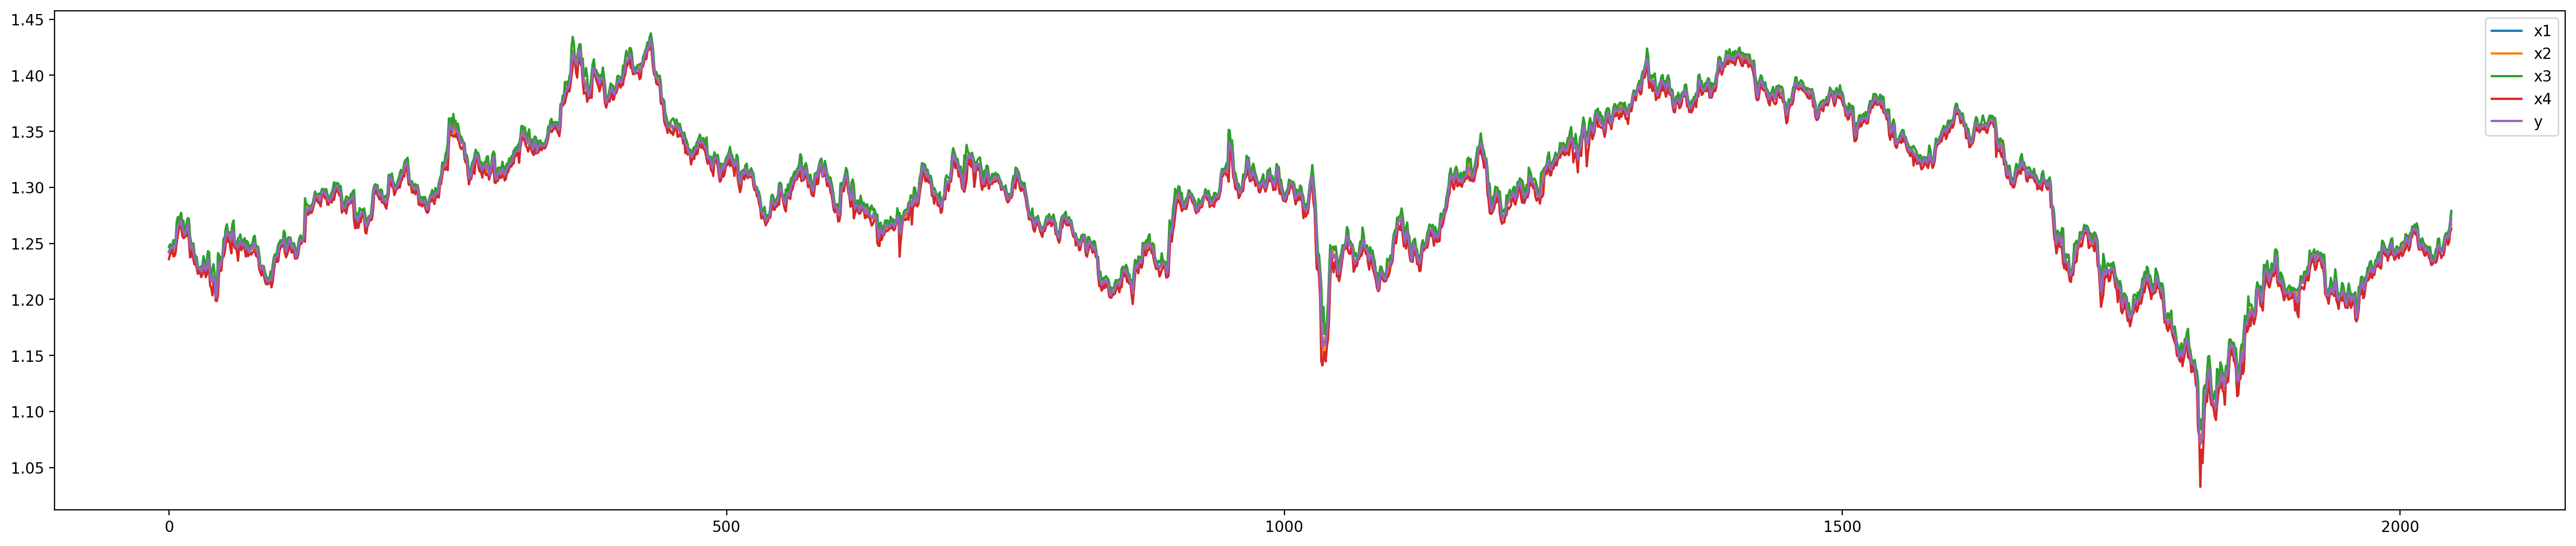

In [9]:
plt.figure(figsize=(30, 6))
plt.plot(x_1[:-1] , label='x1')
plt.plot(x_2[:-1] , label='x2')
plt.plot(x_3[:-1] , label='x3')
plt.plot(x_4[:-1] , label='x4')
plt.plot(y[:-1] , label='y')
plt.legend(loc='upper right')
# plt.title("Dataset" ,  fontsize=18)
# plt.xlabel('Time step' ,  fontsize=18)
# plt.ylabel('Values' , fontsize=18)
plt.legend()
plt.show()

In [10]:
# convert to [rows, columns] structure
x_1 = x_1.reshape((len(x_1), 1))
x_2 = x_2.reshape((len(x_2), 1))
x_3 = x_2.reshape((len(x_3), 1))
x_4 = x_2.reshape((len(x_4), 1))
y = y.reshape((len(y), 1))

print ("x_1.shape" , x_1.shape)
print ("x_2.shape" , x_2.shape)
print ("y.shape" , y.shape)

x_1.shape (2048, 1)
x_2.shape (2048, 1)
y.shape (2048, 1)


In [11]:
# normalization features
scaler = MinMaxScaler(feature_range=(0, 1))
x_1_scaled = scaler.fit_transform(x_1)
x_2_scaled = scaler.fit_transform(x_2)
x_3_scaled = scaler.fit_transform(x_3)
x_4_scaled = scaler.fit_transform(x_4)
y_scaled = scaler.fit_transform(y)

# horizontally stack columns
dataset_stacked = hstack((x_1_scaled, x_2_scaled, x_3_scaled, x_4_scaled, y_scaled))

print ("dataset_stacked.shape" , dataset_stacked.shape)

dataset_stacked.shape (2048, 5)


In [12]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out-1
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)


In [13]:
## choose a number of time steps #change this accordingly
n_steps_in, n_steps_out = 60 , 30

# covert into input/output
X, y = split_sequences(dataset_stacked, n_steps_in, n_steps_out)

print ("X.shape" , X.shape)
print ("y.shape" , y.shape)

split = int(len(X)*0.9)
train_X , train_y = X[:split, :] , y[:split, :]
test_X , test_y = X[split:, :] , y[split:, :]

n_features = train_X.shape[2]


print ("train_X.shape" , train_X.shape)
print ("train_y.shape" , train_y.shape)
print ("test_X.shape" , test_X.shape)
print ("test_y.shape" , test_y.shape)
print ("n_features" , n_features)

X.shape (1960, 60, 4)
y.shape (1960, 30)


**LSTM Model Parameter Setting**

In [16]:
#optimizer learning rate
# opt = keras.optimizers.Adam(learning_rate=0.01)

# define model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(n_steps_out))
# model.add(Activation('linear'))
model.compile(loss='mse' , optimizer='adam' , metrics=['accuracy'])


In [17]:
try:
    model = load_model('TS_model.h5')
except OSError as e:
    print("Model is not loaded, Training model now:", e)
    # Fit network
    history = model.fit(train_X, train_y , epochs=25,  
                        verbose=1,validation_data=(test_X, test_y), 
                        validation_split = 0.1, shuffle=False)
    model.save('TS_model.h5')
    

Model is not loaded, Training model now: No file or directory found at TS_model.h5
Epoch 1/25
56/56 [==============================] - 5s 42ms/step - loss: 0.1924 - accuracy: 0.0425 - val_loss: 0.0143 - val_accuracy: 0.0459
Epoch 2/25
56/56 [==============================] - 2s 37ms/step - loss: 0.0183 - accuracy: 0.0561 - val_loss: 0.0061 - val_accuracy: 0.0255
Epoch 3/25
56/56 [==============================] - 2s 37ms/step - loss: 0.0088 - accuracy: 0.0573 - val_loss: 0.0058 - val_accuracy: 0.0510
Epoch 4/25
56/56 [==============================] - 2s 37ms/step - loss: 0.0106 - accuracy: 0.0590 - val_loss: 0.0056 - val_accuracy: 0.0510
Epoch 5/25
56/56 [==============================] - 2s 33ms/step - loss: 0.0160 - accuracy: 0.0510 - val_loss: 0.0053 - val_accuracy: 0.0561
Epoch 6/25
56/56 [==============================] - 2s 33ms/step - loss: 0.0217 - accuracy: 0.0420 - val_loss: 0.0040 - val_accuracy: 0.0612
Epoch 7/25
56/56 [==============================] - 2s 34ms/step - loss

C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


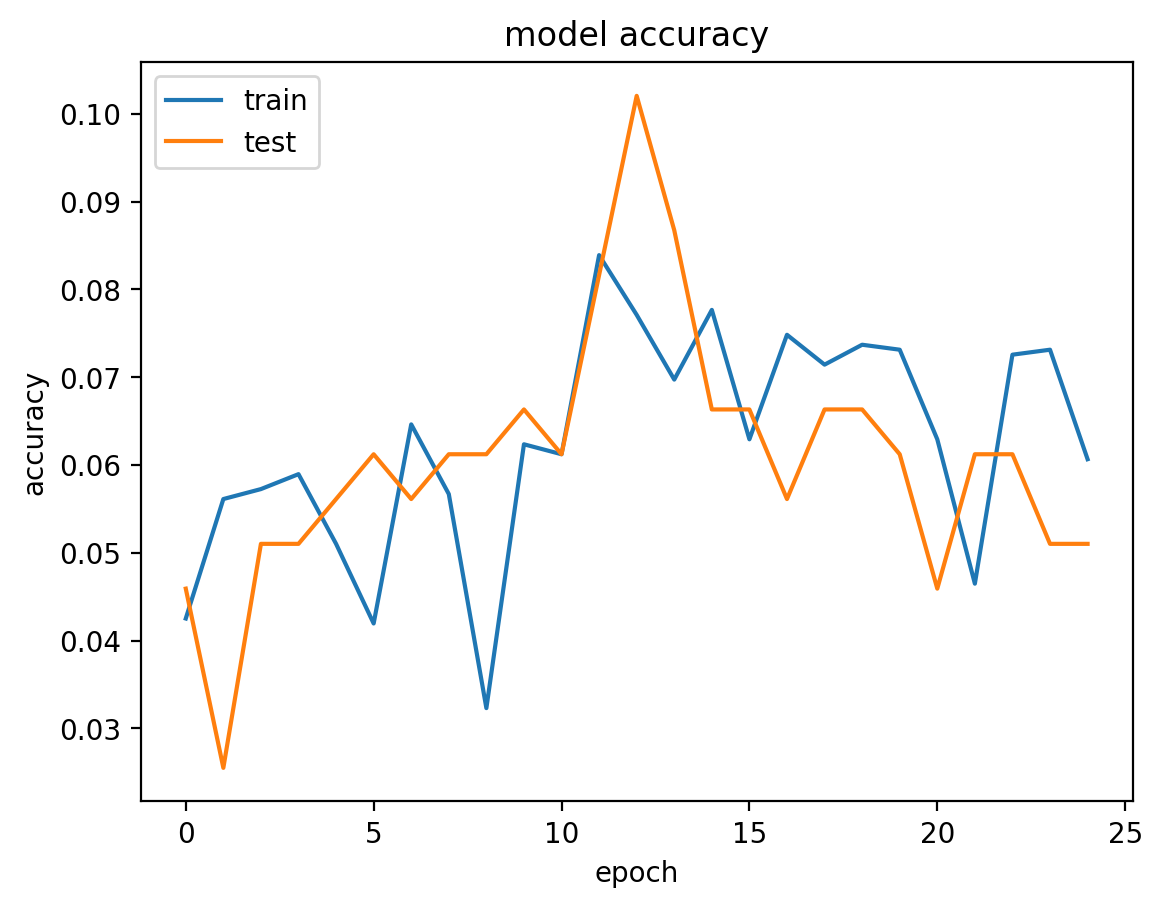

In [19]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

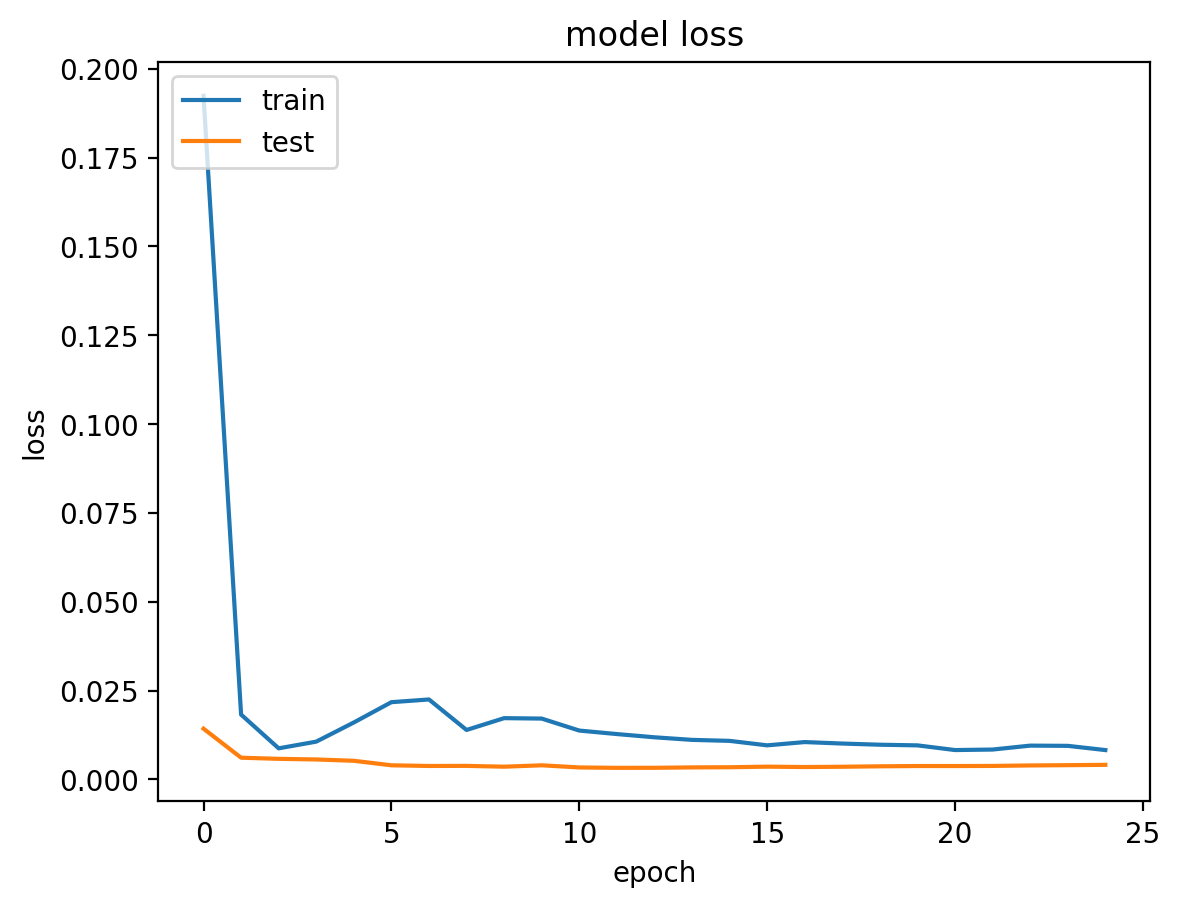

In [20]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [21]:
predicted_price = model.predict(test_X)

7/7 [==============================] - 0s 8ms/step


In [28]:
predicted_price.shape

(197, 20)

In [27]:
test_y.shape

(197, 20)

In [22]:
filler = np.ones((test_y.shape[1]))
filler[:] = np.nan

In [23]:
ac_avg_filler = np.concatenate((filler, np.average(test_y, axis=1)))

In [24]:
pr_price_avg = np.average(predicted_price, axis=1)
# actual_avg = np.average(test_y, axis=1)

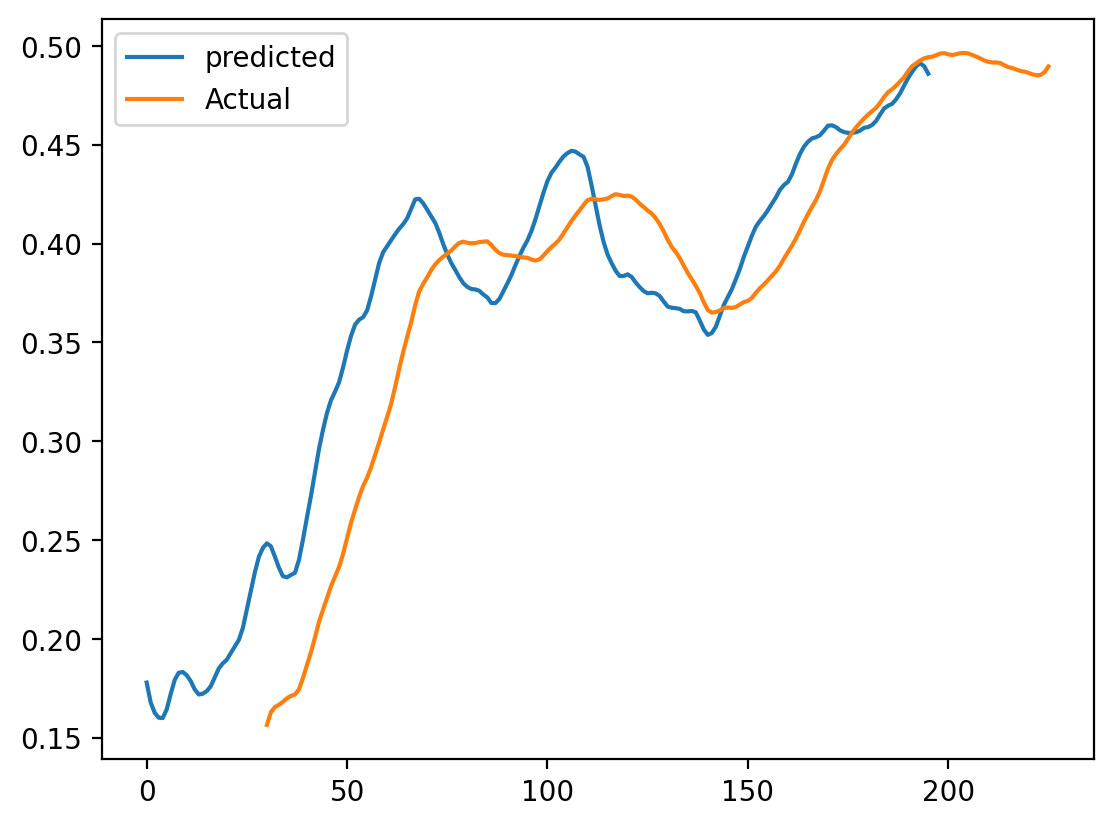

In [25]:
plt.plot(pr_price_avg, label='predicted')
plt.plot(ac_avg_filler, label = 'Actual')
plt.legend()
plt.show()

In [26]:
pr_price_avg_df = pd.DataFrame(pr_price_avg.reshape(-1,1), columns=['prediction'])

In [27]:
pr_price_avg_df

,prediction
0,0.177947
1,0.167945
2,0.162685
3,0.160183
4,0.159973
...,...
191,0.486979
192,0.489727
193,0.491310
194,0.489697


In [28]:
def generate_ema(dataframe, ema_span, col_name):
    ema_col = 'EWMA'+ str(ema_span)
    dataframe[ema_col] = dataframe[col_name].ewm(span=ema_span, adjust=False).mean()
    return dataframe

In [29]:
# Define periods for short and long moving averages
short_period = 2
long_period = 3

In [30]:
pr_price_avg_df = generate_ema(pr_price_avg_df, short_period, 'prediction')
pr_price_avg_df = generate_ema(pr_price_avg_df, long_period, 'prediction')

In [39]:
threshold = 0.002
# pr_price_avg_df['Signal'] = np.where((pr_price_avg_df['EWMA2'] - 
#                                      pr_price_avg_df['EWMA3']) > threshold, 
#                                      1, 0)
# pr_price_avg_df['Signal'] = np.where((pr_price_avg_df['EWMA2'] - 
#                                      pr_price_avg_df['EWMA3']) < -threshold, 
#                                      -1, pr_price_avg_df['Signal'])

pr_price_avg_df['Signal'] = np.where(pr_price_avg_df['EWMA2']>pr_price_avg_df['EWMA3'],1,-1)

# Calculate the percentage change between consecutive rows
price_change_percentage = pr_price_avg_df['prediction'].pct_change()

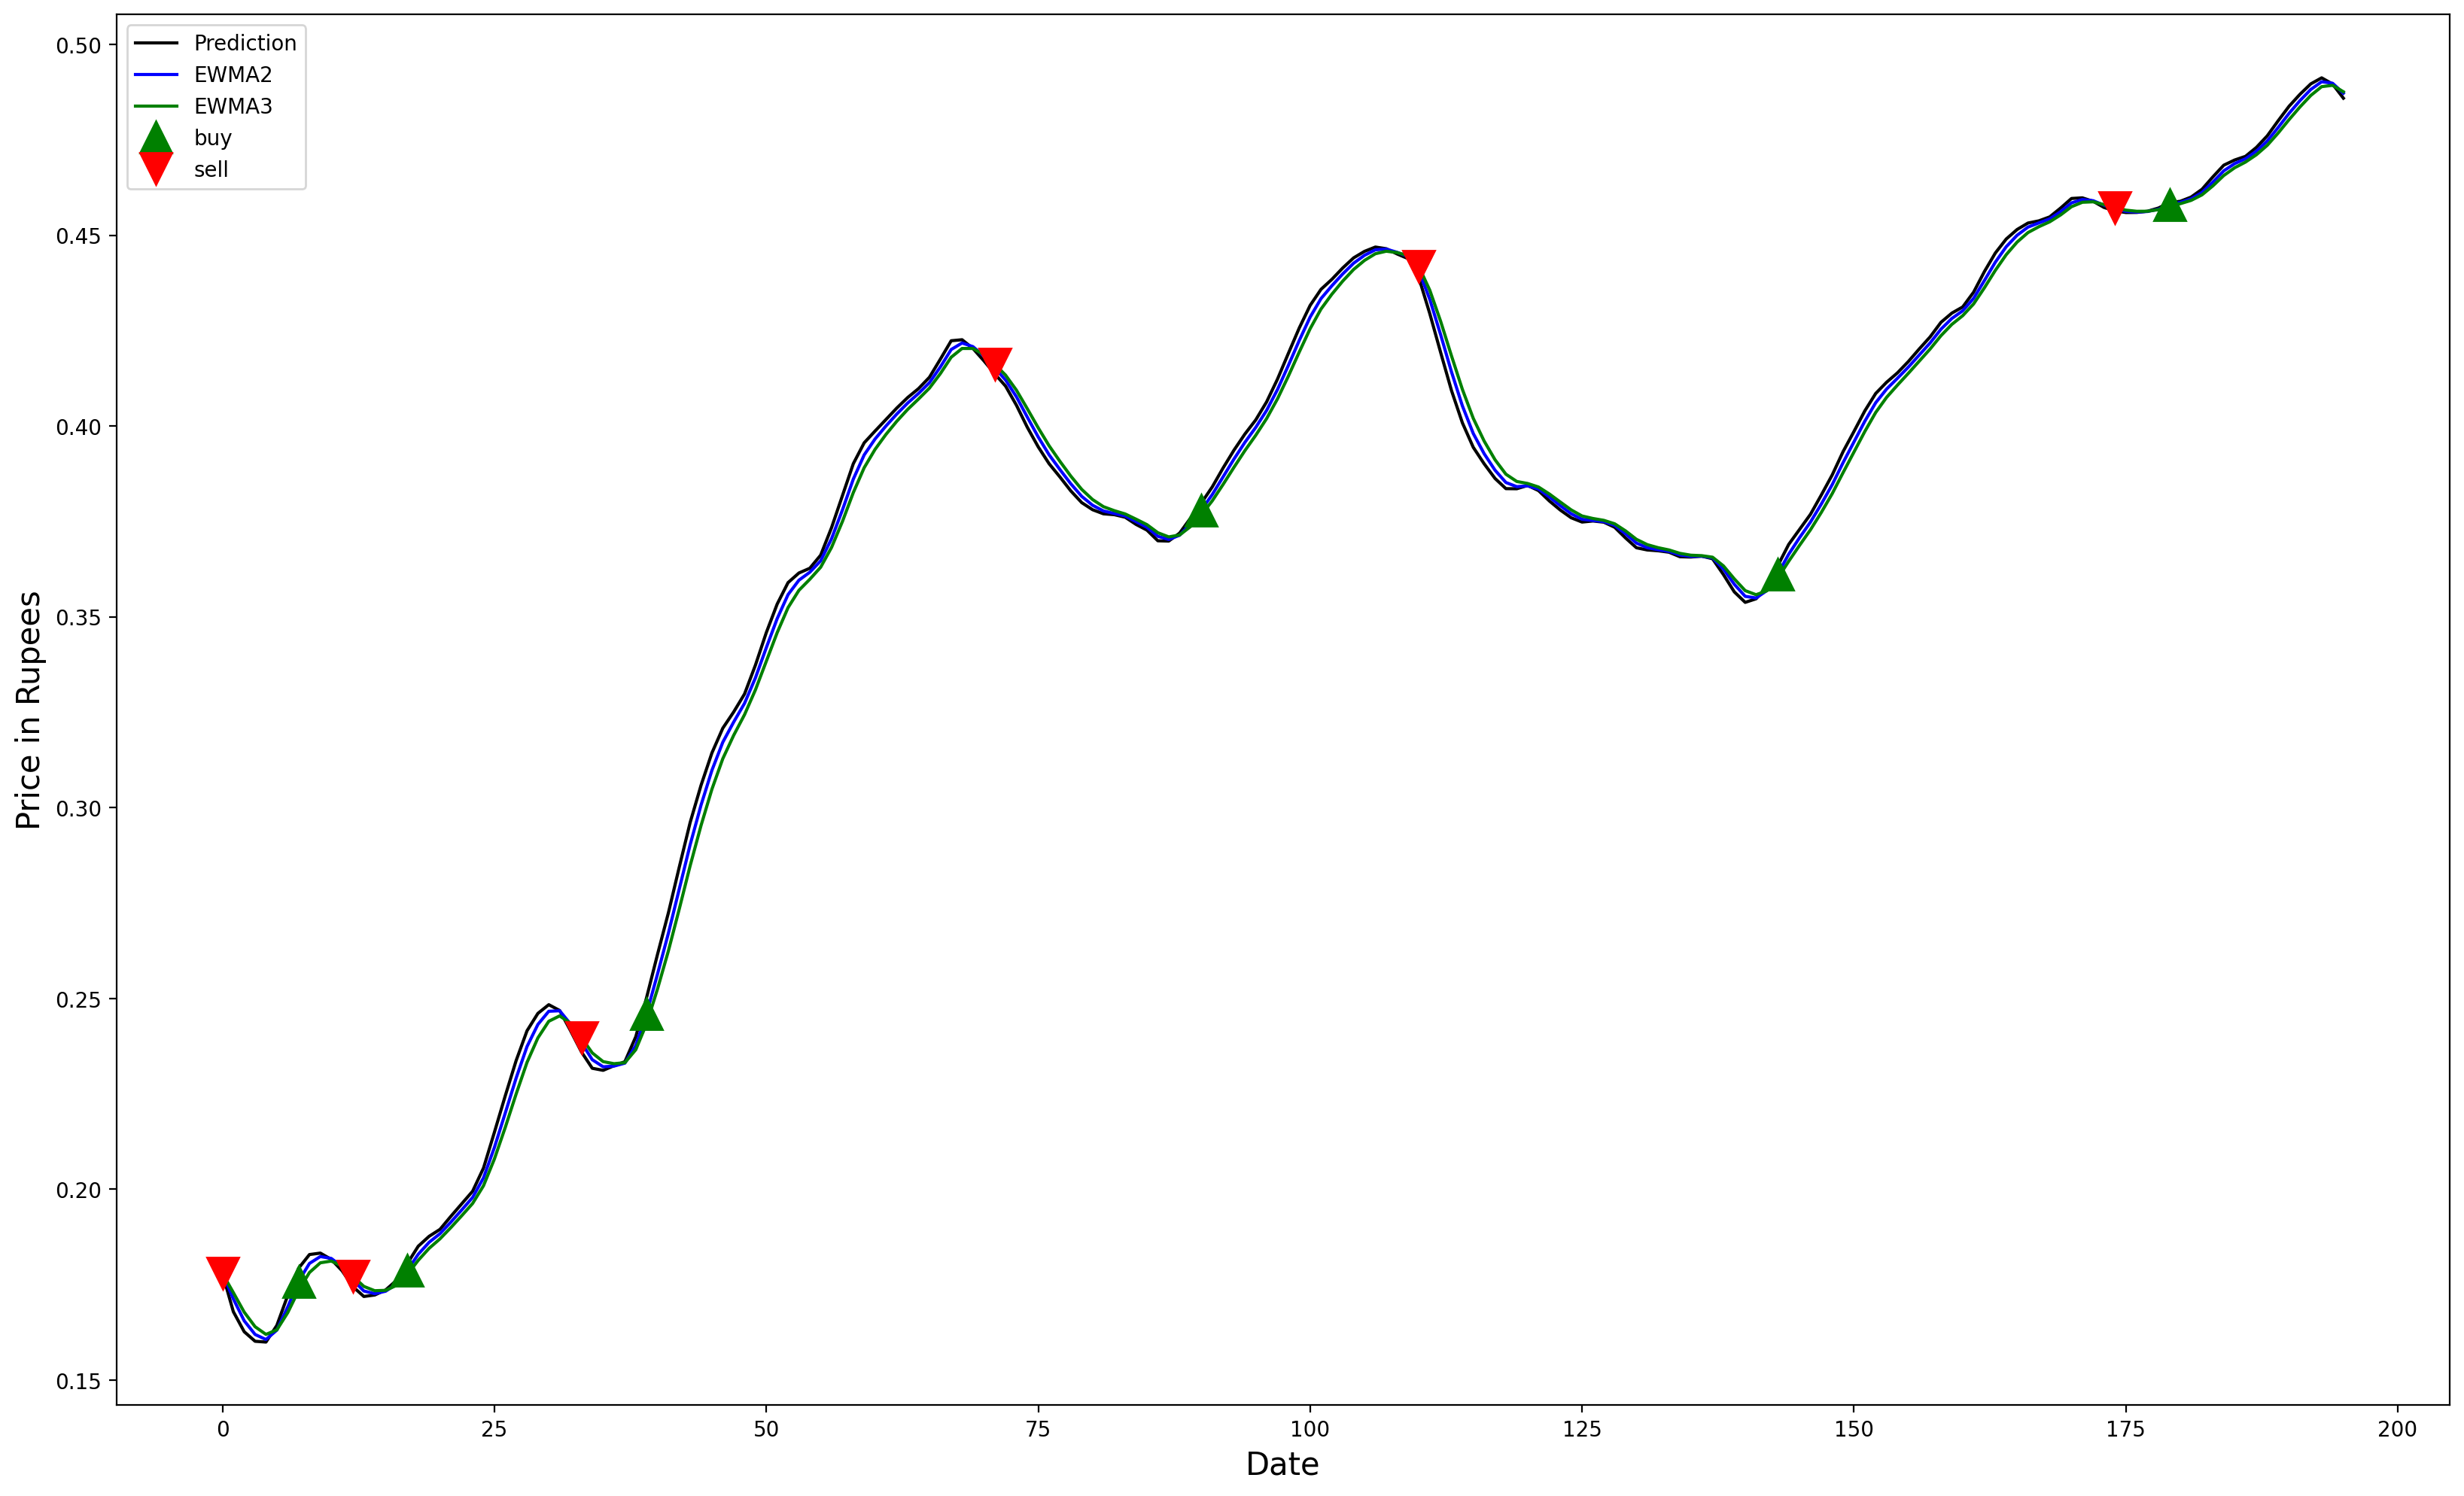

In [41]:
threshold_percentage_change = 0.008

flag=1
for i in range(0, len(pr_price_avg_df)-1):
    if pr_price_avg_df.at[i, 'Signal']==1 and pr_price_avg_df.at[i+1, 'Signal']==1 and flag==1:
        flag=-1
    elif pr_price_avg_df.at[i, 'Signal']==1 and pr_price_avg_df.at[i+1, 'Signal']==1 and flag==-1:
        pr_price_avg_df.at[i, 'Signal'] = 0
    elif pr_price_avg_df.at[i, 'Signal']==-1 and pr_price_avg_df.at[i+1, 'Signal']==-1 and flag==1:
        flag=-1
    elif pr_price_avg_df.at[i, 'Signal']==-1 and pr_price_avg_df.at[i+1, 'Signal']==-1 and flag==-1:
        pr_price_avg_df.at[i, 'Signal'] = 0
    elif (pr_price_avg_df.at[i, 'Signal']==-1 and pr_price_avg_df.at[i+1, 'Signal']==1):
        pr_price_avg_df.at[i, 'Signal'] = 0
        pr_price_avg_df.at[i+1, 'Signal'] = 0
        pr_price_avg_df.at[i+2, 'Signal'] = 1
    elif pr_price_avg_df.at[i, 'Signal']==1 and pr_price_avg_df.at[i+1, 'Signal']==-1:
        pr_price_avg_df.at[i, 'Signal'] = 0
        pr_price_avg_df.at[i+1, 'Signal'] = 0
        pr_price_avg_df.at[i+2, 'Signal'] = -1
#     elif abs(price_change_percentage[i]) < threshold_percentage_change:
#         pr_price_avg_df.at[i, 'Signal'] = 0
    else:
        flag=1

plt.figure(figsize = (20,12))
# plot close price, short-term and long-term moving averages 
pr_price_avg_df['prediction'].plot(color = 'k', label= 'Prediction') 
pr_price_avg_df['EWMA2'].plot(color = 'b',label = 'EWMA2') 
pr_price_avg_df['EWMA3'].plot(color = 'g', label = 'EWMA3')
# plot ‘buy’ signals
plt.plot(pr_price_avg_df[pr_price_avg_df['Signal'] == 1].index, 
         pr_price_avg_df['EWMA2'][pr_price_avg_df['Signal'] == 1], 
         '^', markersize = 15, color = 'g', label = 'buy')
# plot ‘sell’ signals
plt.plot(pr_price_avg_df[pr_price_avg_df['Signal'] == -1].index, 
         pr_price_avg_df['EWMA3'][pr_price_avg_df['Signal'] == -1], 
         'v', markersize = 15, color = 'r', label = 'sell')
plt.ylabel('Price in Rupees', fontsize = 15 )
plt.xlabel('Date', fontsize = 15 )
plt.legend()
plt.show()

In [159]:
import numpy as np
import pandas as pd

def generate_signals(data, short_window, long_window):
    signals = pd.DataFrame(index=data.index)
    signals['price'] = data['Close']
    
    # Create short and long moving averages
    signals['short_mavg'] = data['Close'].rolling(window=short_window, min_periods=1, center=False).mean()
    signals['long_mavg'] = data['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

    # Generate signals
    signals['signal'] = 0.0
    signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] > signals['long_mavg'][short_window:], 1.0, 0.0)

    # Generate buy/sell signals
    signals['positions'] = signals['signal'].diff()

    return signals

# Example usage
if __name__ == "__main__":
    # Example data (replace with your own)
    data = pd.DataFrame({'Close': [10, 11, 12, 13, 14, 15, 14, 13, 12, 11, 10]})
    
    # Parameters
    short_window = 3
    long_window = 6
    
    # Generate signals
    signals = generate_signals(data, short_window, long_window)
    
    # Output signals
    print(signals)


    price  short_mavg  long_mavg  signal  positions
0      10   10.000000  10.000000     0.0        NaN
1      11   10.500000  10.500000     0.0        0.0
2      12   11.000000  11.000000     0.0        0.0
3      13   12.000000  11.500000     1.0        1.0
4      14   13.000000  12.000000     1.0        0.0
5      15   14.000000  12.500000     1.0        0.0
6      14   14.333333  13.166667     1.0        0.0
7      13   14.000000  13.500000     1.0        0.0
8      12   13.000000  13.500000     0.0       -1.0
9      11   12.000000  13.166667     0.0        0.0
10     10   11.000000  12.500000     0.0        0.0


C:\Users\iftek\AppData\Local\Temp\ipykernel_15952\3767474636.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] > signals['long_mavg'][short_window:], 1.0, 0.0)


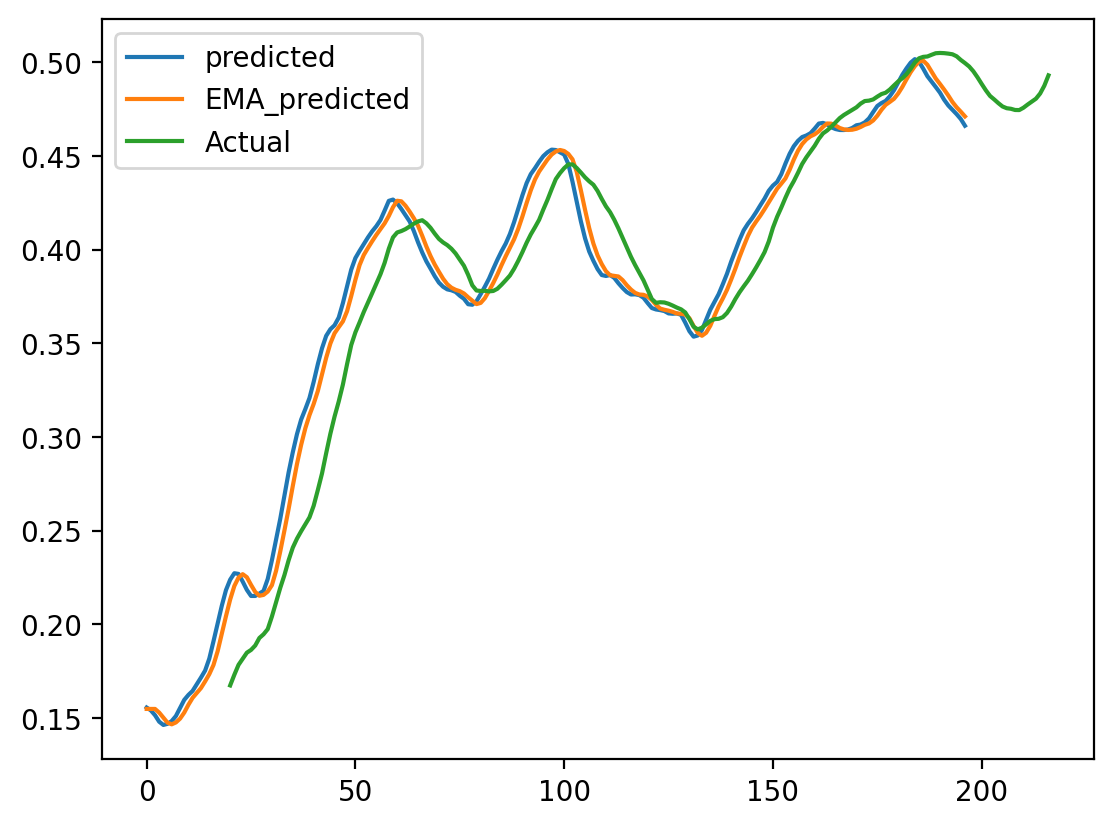

In [64]:
ema_predicted = exponential_moving_average(pr_price_avg, period=3)

plt.plot(pr_price_avg, label='predicted')
plt.plot(ema_predicted, label = 'EMA_predicted')
plt.plot(ac_avg_filler, label = 'Actual')
plt.legend()
plt.show()

In [38]:
predict_avg = np.concatenate((filler, np.average(predicted_price, axis=1)))


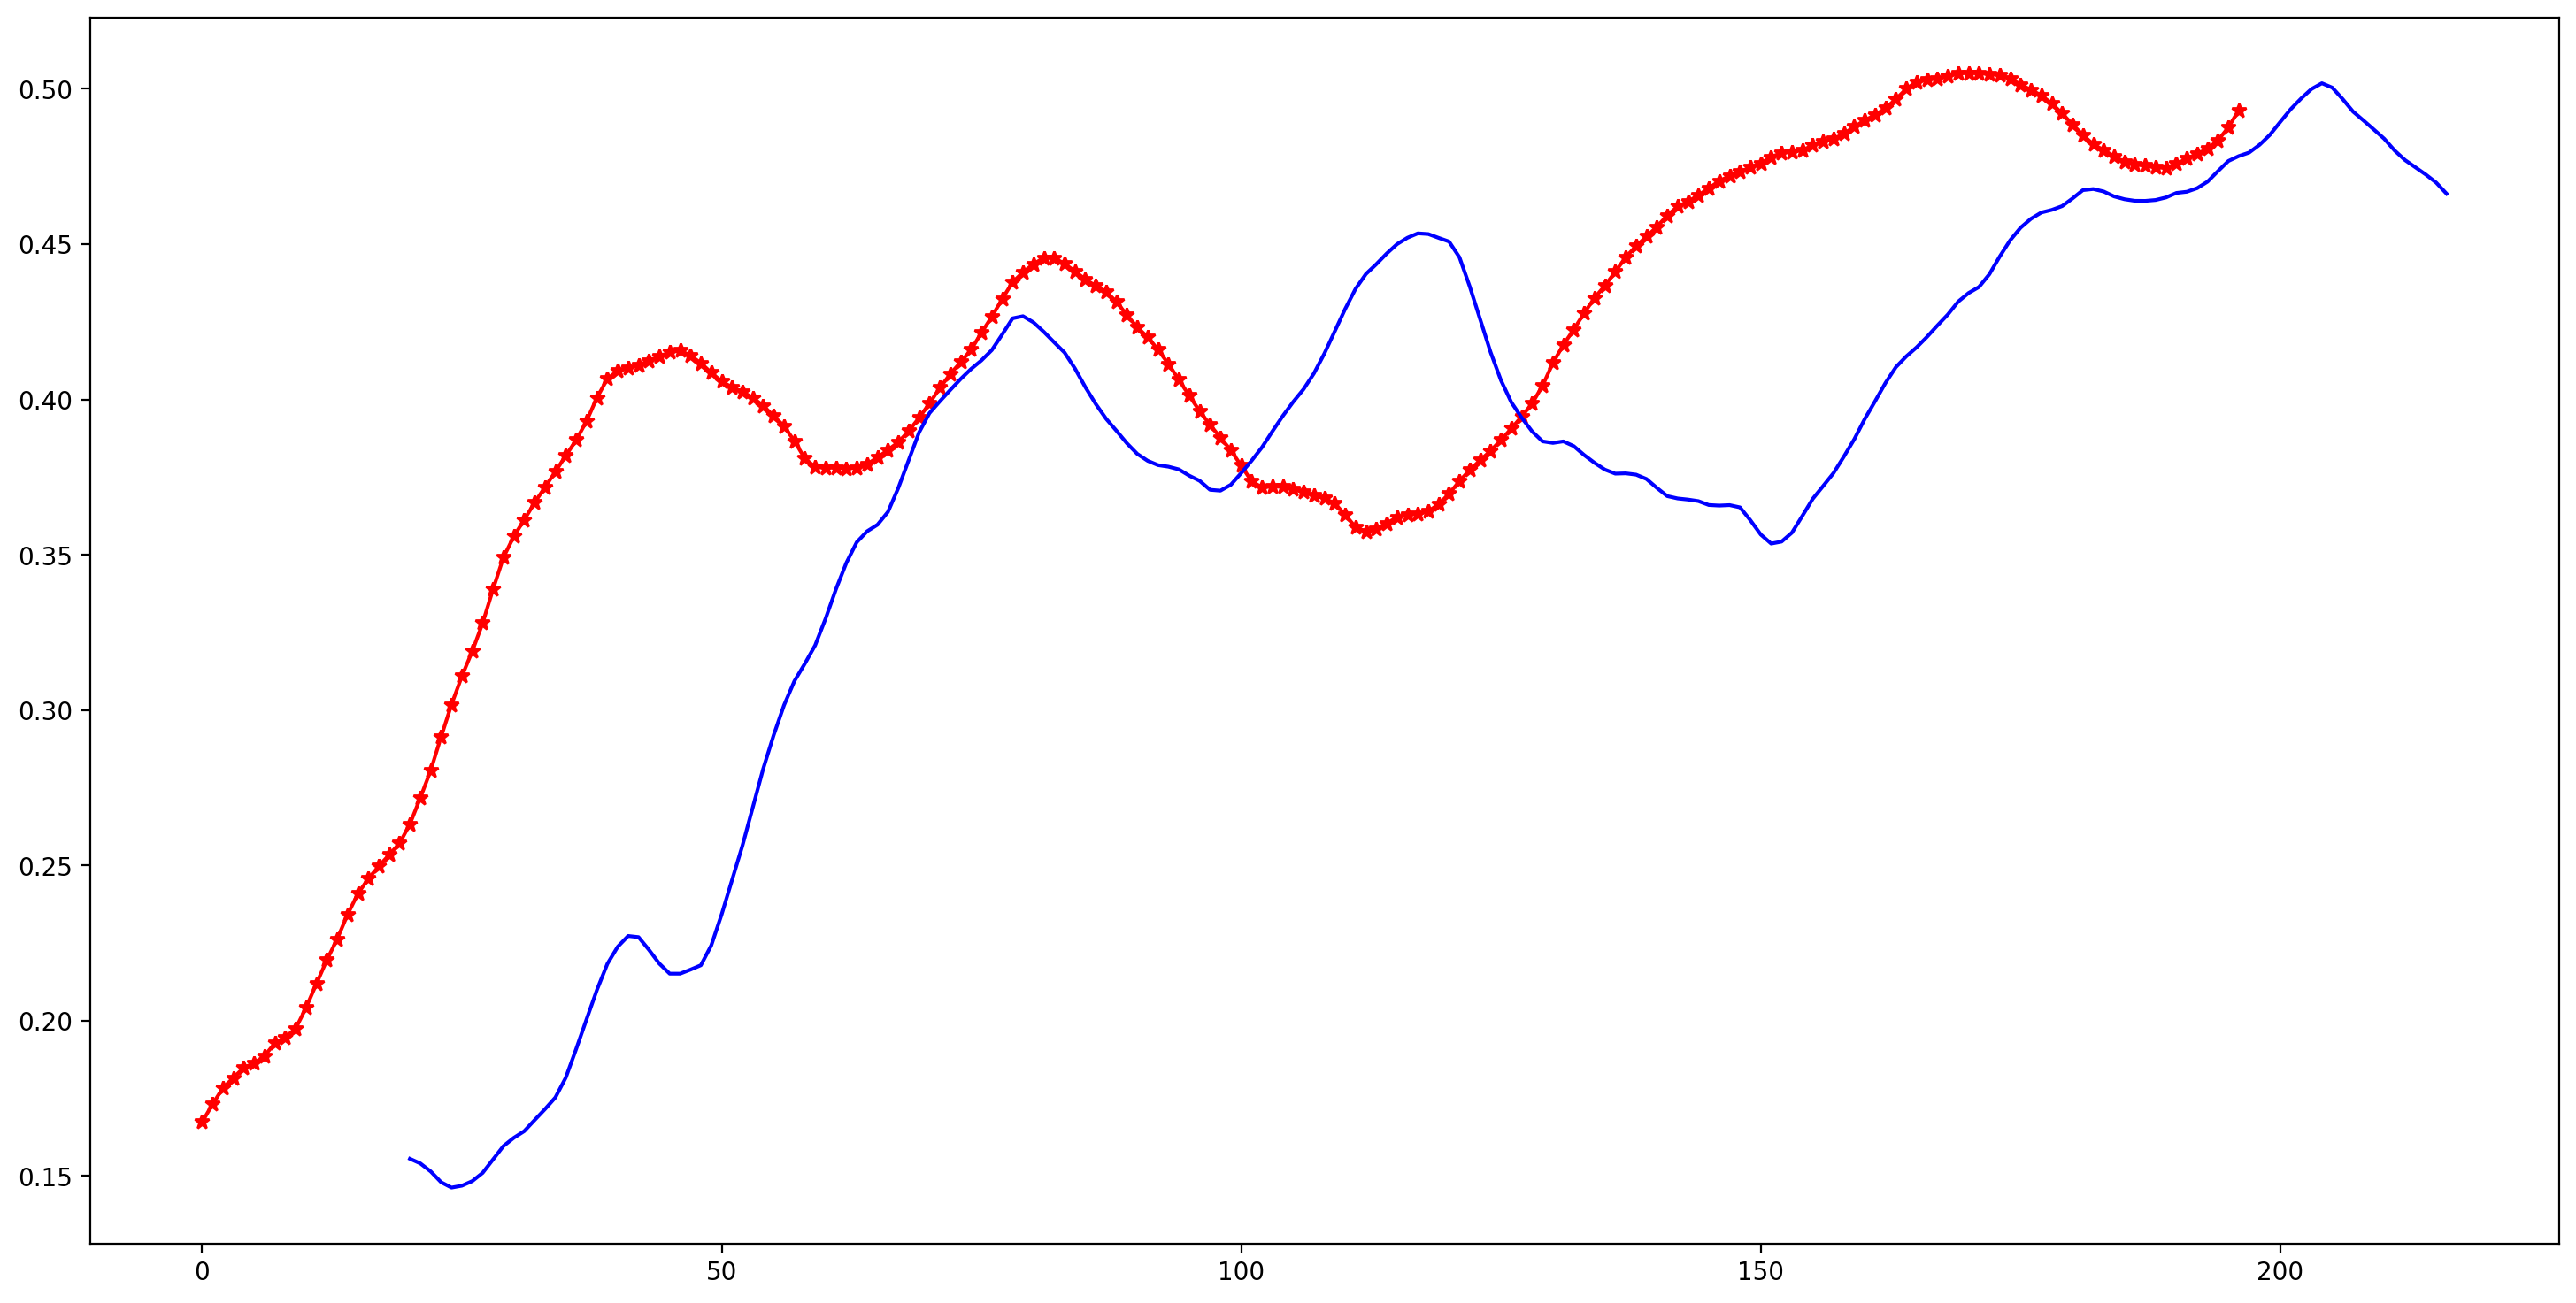

In [39]:
plt.figure(figsize=(18,9))
# plt.plot(training_set_scaled)
plt.plot(actual_avg, color='red', marker='*')
plt.plot(predict_avg, color='blue')

Evaluation



In [73]:
# Test Data Batch 1 , Test Data Batch 2 , Test Data Batch 3
url_test = 'H4_EURUSD.csv'
dataset_test_ok = pd.read_csv(url_test, usecols=['open', 'high', 'low', 'close'])
dataset_test_ok = dataset_test_ok.iloc[:500, :]
dataset_test_ok['avg'] = dataset_test_ok.iloc[:,0:-1].mean(axis=1)
dataset_test_ok.head()

,open,high,low,close,avg
0,1.0088,1.0106,1.0061,1.0062,1.008500
1,1.0073,1.0190,1.0073,1.0175,1.011200
2,1.0173,1.0181,1.0154,1.0157,1.016933
3,1.0154,1.0167,1.0093,1.0115,1.013800
4,1.0118,1.0118,1.0054,1.0073,1.009667


In [74]:
# read test data
x1_test = dataset_test_ok['open'].values
x2_test = dataset_test_ok['high'].values
x3_test = dataset_test_ok['low'].values
x4_test = dataset_test_ok['close'].values
y_test = dataset_test_ok['avg'].values # no need to scale

# convert to [rows, columns] structure
x1_test = x1_test.reshape((len(x1_test), 1))
x2_test = x2_test.reshape((len(x2_test), 1))
x3_test = x3_test.reshape((len(x3_test), 1))
x4_test = x4_test.reshape((len(x4_test), 1))
y_test = y_test.reshape((len(y_test), 1))

x1_test_scaled = scaler.fit_transform(x1_test)
x2_test_scaled = scaler.fit_transform(x2_test)
x3_test_scaled = scaler.fit_transform(x3_test)
x4_test_scaled = scaler.fit_transform(x4_test)


In [75]:
def prep_data(x1_test_scaled , x2_test_scaled , x3_test_scaled, x4_test_scaled, y_test , start , end , last):
    #prepare test data X
    dataset_test = hstack((x1_test_scaled, x2_test_scaled, x3_test_scaled, x4_test_scaled))
    dataset_test_X = dataset_test[start:end, :]
    test_X_new = dataset_test_X.reshape(1, dataset_test_X.shape[0] , dataset_test_X.shape[1])

    #prepare past and groundtruth
    past_data = y_test[:end , :]
    dataset_test_y = y_test[end:last , :]
    scaler1 = MinMaxScaler(feature_range=(0, 1))
    scaler1.fit(dataset_test_y)

    # predictions
    y_pred = model.predict(test_X_new)
    y_pred_inv = scaler1.inverse_transform(y_pred)
    y_pred_inv = y_pred_inv.reshape(n_steps_out,1)
    y_pred_inv = y_pred_inv[:,0]

    return y_pred_inv , dataset_test_y , past_data

# Calculate MAE and RMSE
def evaluate_prediction(predictions, actual, model_name , start , end):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()

    print("Test Data from {} to {}".format(start, end))
    print('Mean Absolute Error: {:.2f}'.format(mae))
    print('Root Mean Square Error: {:.2f}'.format(rmse))
    print('')
    print('')

# Plot history and future
def plot_multistep(history, prediction1 , groundtruth , start , end):

    plt.figure(figsize=(20, 4))

    y_mean = mean(prediction1)

    range_history = len(history)
    range_future = list(range(range_history, range_history + len(prediction1)))

    plt.plot(np.arange(range_history), np.array(history), label='History')
    plt.plot(range_future, np.array(prediction1),label='Forecasted with LSTM')
    plt.plot(range_future, np.array(groundtruth),label='GroundTruth')

    plt.legend(loc='upper right')
    plt.title("Test Data from {} to {} , Mean = {:.2f}".format(start, end, y_mean) ,  fontsize=18)
    plt.xlabel('Time step' ,  fontsize=18)
    plt.ylabel('y-value' , fontsize=18)

In [76]:
# Plot history and future
def plot_multistep(history, prediction1 , groundtruth , start , end):
    plt.figure(figsize=(20, 4))
    y_mean = mean(prediction1)
    range_history = len(history)
    range_future = list(range(range_history, range_history + len(prediction1)))
    plt.plot(np.arange(range_history), np.array(history), label='History')
    plt.plot(range_future, np.array(prediction1),label='Forecasted with LSTM')
    plt.plot(range_future, np.array(groundtruth),label='GroundTruth')
    plt.legend(loc='upper right')
    plt.title("Test Data from {} to {} , Mean = {:.2f}".format(start, end, y_mean) ,  fontsize=18)
    plt.xlabel('Time step' ,  fontsize=18)
    plt.ylabel('y-value' , fontsize=18)

In [63]:
mean(y_pred_inv)

0.9672512

1/1 [==============================] - 0s 26ms/step
Test Data from 120 to 180
Mean Absolute Error: 0.00
Root Mean Square Error: 0.00


1/1 [==============================] - 0s 17ms/step
Test Data from 180 to 240
Mean Absolute Error: 0.00
Root Mean Square Error: 0.00




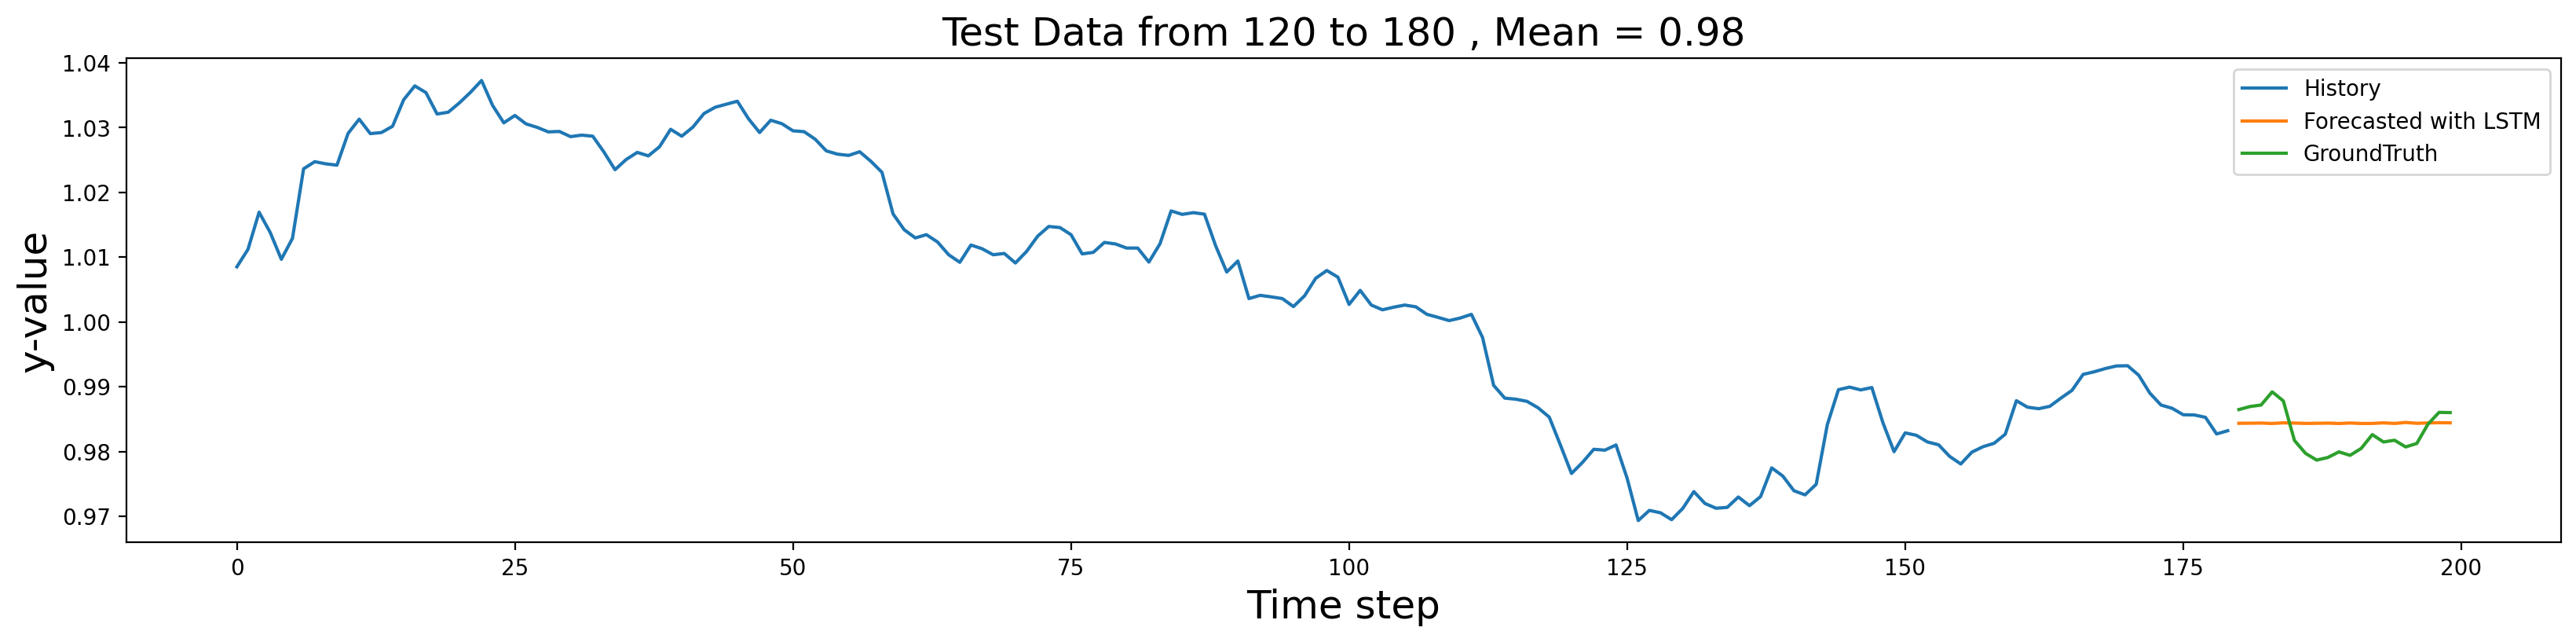

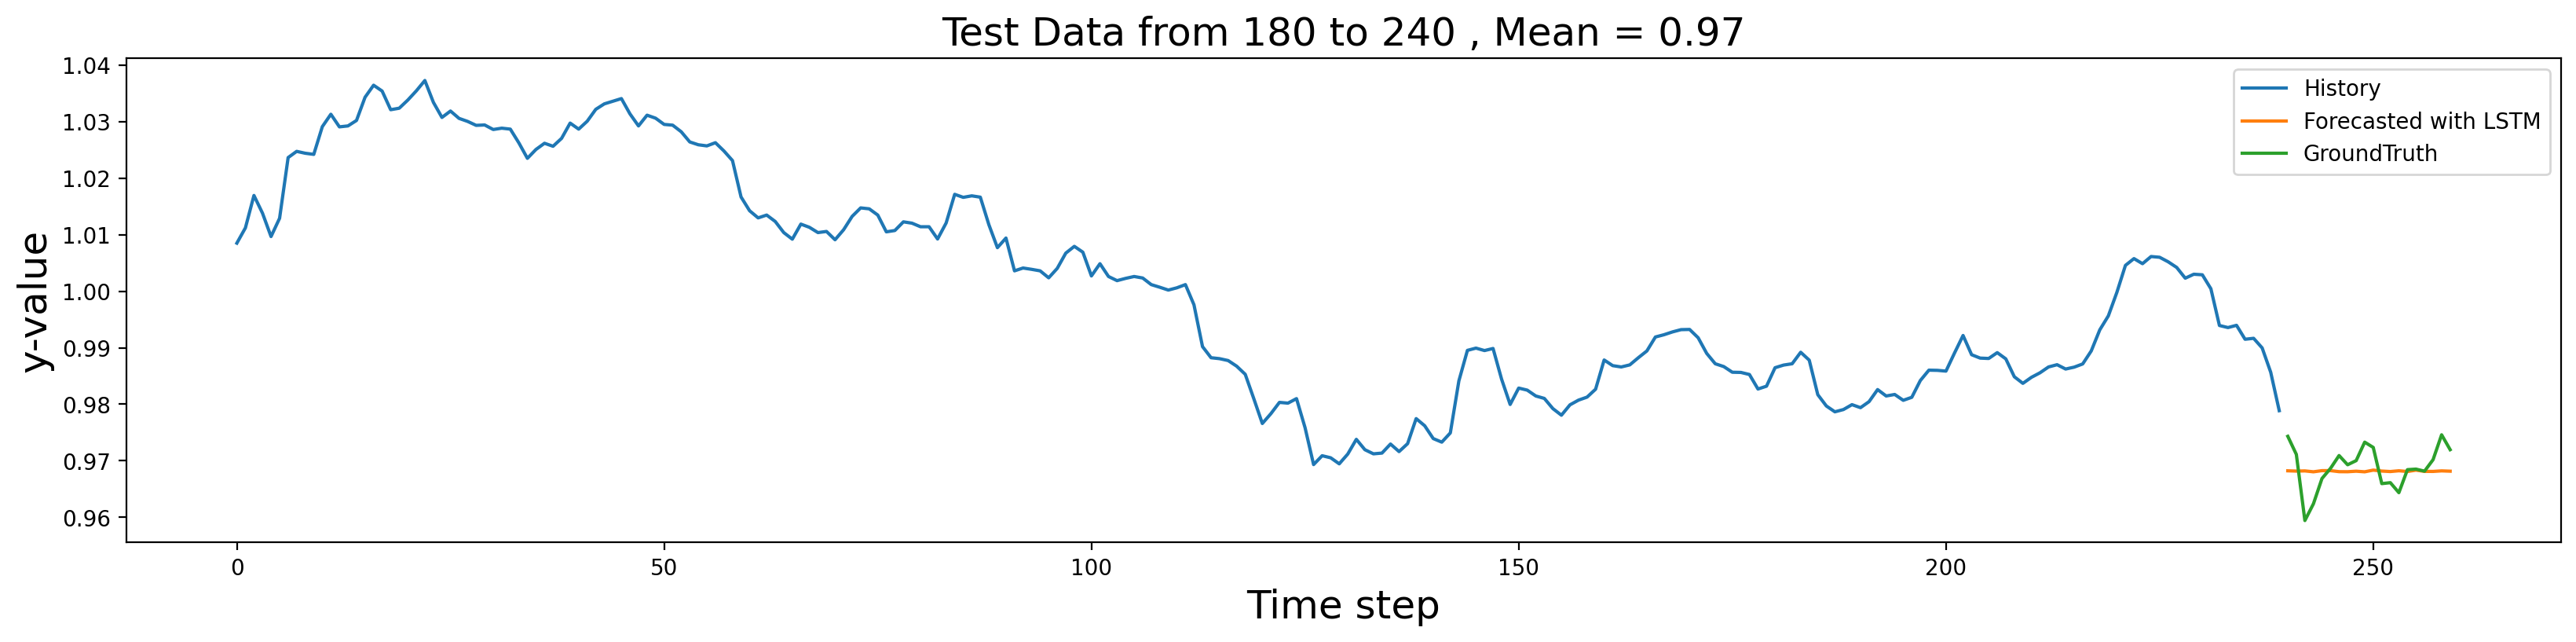

In [77]:
for i in range(120,240,60):
    start = i
    end = start + n_steps_in
    last = end + n_steps_out    
    y_pred_inv , dataset_test_y , past_data = prep_data(x1_test_scaled , x2_test_scaled , x3_test_scaled , x4_test_scaled , y_test , start , end , last)
    evaluate_prediction(y_pred_inv , dataset_test_y, 'LSTM' , start , end)
    plot_multistep(past_data , y_pred_inv , dataset_test_y , start , end)


Save & Load


In [ ]:
# model_url = '/Directory/Filename.h5'
# model.save(model_url)
# print("Saved")

In [ ]:
# model_url = '/Directory/Filename.h5'
# model = load_model(model_url)
# print("Loaded")
# model.summary()